# 0 TCLab Overview

The following cells in this notebook demonstrate the use of the Temperature Control Lab. Before going further, be sure to complete the steps outlined under *Hardware setup* as described in TCLab [README](https://github.com/jckantor/TCLab/blob/master/README.rst).

## TCLab Architecture
<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Jupyter notebooks:_**
Examples, lessons, and student projects.

**_tclab:_**
A package to provide high-level access to sensors, heaters, a pseudo-realtime clock. The package includes `TCLab()` providing access to the device, `clock` for synchronizing with a real time clock, `Historian` for data logging and `Plotter` for realtime plotting.

**_sketch.ino:_**
Firmware for the intrisically safe operation of the Arduino board and shield.

**_Arduino:_**
Hardware platform for the Temperature Control Laboratory. Compatiable with Arduino Uno and Arduino Leonardo.

## Connecting to the Temperature Control Laboratory

### Importing

When used for the first time, the `tclab` package is installed with the command line

    pip install tclab
    
Once it has been installed, the package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    a = TCLab()

TCLab() attempts to find a device connected to a serial port and returns a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [1]:
from tclab import TCLab

a = TCLab()
a.LED(100)
a.close()

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
TCLab disconnected successfully.


### Using TCLab with Python's `with` statement

The Python `with` statement provides a convenient means of setting up and closing a connection to the Temperature Control Laboratory. In particular, the with statement establishes a context where a tclab instance is created, assigned to a variable, and automatically closed upon completion.

In [2]:
from tclab import TCLab

with TCLab() as a:
    a.LED(100)

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
TCLab disconnected successfully.


The `with` statement is likely to be the most common way to connect the Temperature Control Laboratory for most uses.

## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `a`, the temperatures are accessed as

    T1 = a.T1
    T2 = a.T2

Note that `a.T1` and `a.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [3]:
from tclab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} °C".format(a.T1))
    print("Temperature 2: {0:0.2f} °C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
Temperature 1: 27.34 °C
Temperature 2: 27.67 °C
TCLab disconnected successfully.


## Setting Heaters

The heaters are controlled by functions`.Q1()` and `.Q2()` of a tclab instance. For example, both heaters can be set to 100% power with the functions

    a.Q1(100)
    a.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = a.Q1()
    Q2 = a.Q2()
    
Note that the retrieved values may be different due to the range-limiting enforced by the device firmware.

In [4]:
from tclab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} °C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} °C".format(a.T2),flush=True)

    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    t_heat = 30
    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1(0)
    a.Q2(0)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    print("\nFinal Temperature 1: {0:0.2f} °C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} °C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411

Starting Temperature 1: 27.34 °C
Starting Temperature 2: 27.34 °C

Set Heater 1: 100.0 %
Set Heater 2: 100.0 %

Heat for 30 seconds

Turn Heaters Off

Set Heater 1: 0.0 %
Set Heater 2: 0.0 %

Final Temperature 1: 29.28 °C
Final Temperature 2: 27.99 °C
TCLab disconnected successfully.


## Synchronizing with Real Time using `clock`

For convenience, the tclab module includes a function `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` is a python iterator that generates a sequence of iterations over a period of `tperiod` seconds separated by `tstep` seconds. 

In [5]:
from tclab import TCLab, clock

tperiod = 5
tstep = 1
for t in clock(tperiod,tstep):
    print(t, "sec.")

0.0 sec.
1.0 sec.
2.0 sec.
2.99 sec.
3.99 sec.
4.99 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with the wall clock, but there can be no guarantees.

The default behavior of `clock` is to try to maintain equal time steps. If an event occurs that causes the clock to get of sync with real time then the remaining times will all be delayed by that amount.  This behavior is demonstrated in the following cell.

In [6]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal, tstep):
    print(t, "sec.")
    if 3 < t < 5:
        time.sleep(2.2)

0.0 sec.
2.0 sec.
4.0 sec.
6.2 sec.
8.2 sec.
10.2 sec.


When the optional flag `strict` is set to True, then `clock` attempts to maintain synchrony with the real time clock. An exception is raised if `clock` fails to keep up with real time which is demonstrated in the following cell where, for a certain interval, a calculation is performed that takes longer than tstep to complete.

In [7]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
try:
    for t in clock(tfinal, tstep, strict=True):
        print(t, "sec.")
        if 3 < t < 5:
            time.sleep(2.2)
except:
    print("Timing error")

0.0 sec.
2.0 sec.
4.0 sec.
Timing error


This behavior can be modified using the optional parameter `tol`. Roughly speaking, `tol` is allowable deviation of `clock` from the wall clock.

In [8]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal, tstep, strict=True, tol=0.25):
    print(t, "sec.")
    if 3 < t < 5:
        time.sleep(2.2)

0.0 sec.
2.0 sec.
4.0 sec.
6.2 sec.
8.0 sec.
10.0 sec.
12.0 sec.


### Using `clock` with TCLab

In [9]:
from tclab import TCLab, clock

tperiod = 20

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1 to {0:f} %".format(a.Q1()))
    print("Set Heater 2 to {0:f} %".format(a.Q2()))

    # report temperatures for the next tperiod seconds
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} °C    T2 = {2:0.1f} °C"
    for t in clock(tperiod, 2):
        print(sfmt.format(t, a.T1, a.T2), flush=True)
        

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411

Set Heater 1 to 100.000000 %
Set Heater 2 to 100.000000 %
     0.0 sec:   T1 = 29.6 °C    T2 = 28.0 °C
     2.0 sec:   T1 = 29.3 °C    T2 = 28.0 °C
     4.0 sec:   T1 = 29.3 °C    T2 = 28.6 °C
     6.0 sec:   T1 = 29.3 °C    T2 = 28.0 °C
     8.0 sec:   T1 = 29.3 °C    T2 = 28.0 °C
    10.0 sec:   T1 = 29.6 °C    T2 = 28.6 °C
    12.0 sec:   T1 = 29.6 °C    T2 = 28.0 °C
    14.0 sec:   T1 = 29.6 °C    T2 = 28.0 °C
    16.0 sec:   T1 = 29.6 °C    T2 = 28.6 °C
    18.0 sec:   T1 = 29.9 °C    T2 = 29.0 °C
    20.0 sec:   T1 = 29.9 °C    T2 = 28.0 °C
TCLab disconnected successfully.


## The TCLab `Historian`

### Basic logging

The `Historian` class provides data logging. Given an instance of a TCLab object, an Historian is created with the command

    h = Historian(a.sources)
    
The historian initializes a data log. The data log is updated by issuing a command

    h.update(t)
    
Where `t` is the current clock time. If `t` is omitted, the historian will calculate its own time.

In [10]:
from tclab import TCLab, clock, Historian

with TCLab() as a:
    h = Historian(a.sources)
    for t in clock(20, strict = True):
        a.Q1(100 if t <= 10 else 0)
        print("Time:", t, 'seconds')
        h.update(t)        

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
Time: 0.0 seconds
Time: 1.0 seconds
Time: 2.0 seconds
Time: 3.0 seconds
Time: 4.0 seconds
Time: 5.0 seconds
Time: 6.0 seconds
Time: 7.0 seconds
Time: 8.0 seconds
Time: 9.0 seconds
Time: 10.0 seconds
Time: 11.0 seconds
Time: 12.0 seconds
Time: 13.0 seconds
Time: 14.0 seconds
Time: 15.0 seconds
Time: 16.0 seconds
Time: 17.0 seconds
Time: 18.0 seconds
Time: 19.0 seconds
Time: 20.0 seconds
TCLab disconnected successfully.


### Accessing the Data Log from the Historian

`Historian` maintains a data log that is updated on each encounter of the `.update()` function. Individual time series are available as elements of `Historian.fields`:

    t, T1, T2, Q1, Q2 = h.fields 

For example, here's how to plot the history of temperature T1 versus time from the example above.

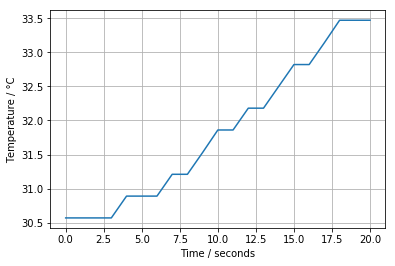

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

t, T1, T2, Q1, Q2 = h.fields 
plt.plot(t, T1)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.grid()

The entire data history is available from the historian as the attribute `.log`. Here we show the first three rows from the log:

In [12]:
h.log[:3]

[(0, 30.57, 28.31, 0.0, 0.0),
 (0.0, 30.57, 28.31, 100.0, 0.0),
 (1.0, 30.57, 28.31, 100.0, 0.0)]

### Accessing log data via Pandas

Here's an example of how the log can be converted to a Pandas dataframe.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

,T1,T2,Q1,Q2
Time,,,,
0.0,30.57,28.31,0.0,0.0
0.0,30.57,28.31,100.0,0.0
1.0,30.57,28.31,100.0,0.0
2.0,30.57,28.31,100.0,0.0
3.0,30.57,28.31,100.0,0.0


The following cells provide examples of plots that can be constructed once the data log has been converted to a pandas dataframe.

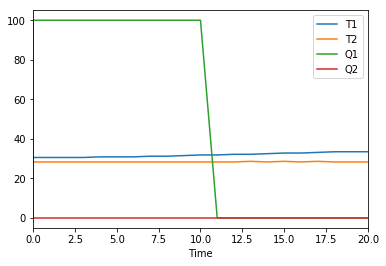

In [14]:
df.plot()

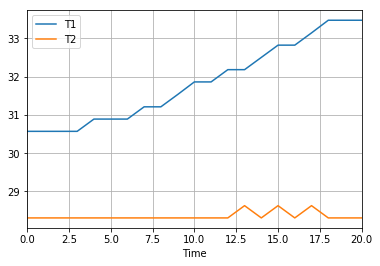

In [15]:
df[['T1','T2']].plot(grid=True)

### Real time plots with Plotter
When operating in a Jupyter Notebook, a `Plotter` can be used together with the `Historian`.  

    h = Historian(a)
    p = Plotter(h, tfinal)
    
where `a` is a `TCLab` instance as before and the optional parameter `tfinal` provides an initial scaling of the time axes. Each call to `p.update()` will automatically update both the historian and the plot.

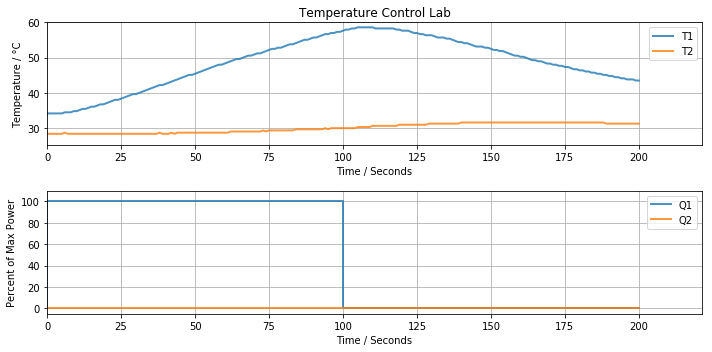

TCLab disconnected successfully.


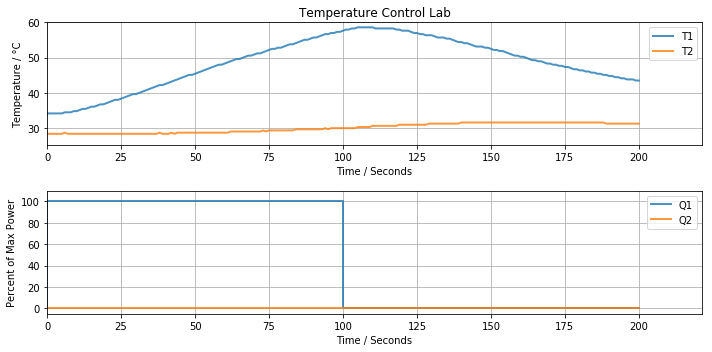

In [16]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200, strict=True):
        a.Q1(100 if t <= 100 else 0)
        p.update(t)